In [12]:
import numpy as np #Linear algebra library
import requests #Used to make http requests to grab g4g pages
import bs4 #Beautiful soup - html parser library
import time #Used to time.sleep to prevent making too many requests to g4g
import os #Used to manipulate local file system to store the scraped data
import copy #Used for copy.deepcopy to copy matrices to get new ones with the same dimensions 
import matplotlib.pyplot as plt #Used to plot the cost function against time for the network.

In [ ]:
def ScrapeG4GResources():
    """Collects articles from Geeks for Geeks articles by web scraping and saves them to the local machine for later processing by the companion subroutine"""
    SAFETY_DELAY = 3 #in seconds, to avoid accidentally DoSing the website which would not be a good outcome.
    STORAGE_PATH = "/content/drive/MyDrive/A Level/Computer Science/NEA/G4G Downloads"

    soup = bs4.BeautifulSoup(requests.get("https://www.geeksforgeeks.org/python-programming-language/").text) #Create a beautiful soup object which will allow us to parse the html of the webpage (screenscrape it)
    articlesLeftPanel = soup.find("article",{"id":"post-136942"}).findChild().find_all("div",recursive=False)[3] #Based on the structure of the G4G Python homepage, we know that the Python articles are found in two panels which are uniquely identified as the 4th and 5th divs inside an article tag with the class post-136942
    articlesRightPanel = soup.find("article",{"id":"post-136942"}).findChild().find_all("div",recursive=False)[4]
    aTags = articlesLeftPanel.find_all("a",href=True) + articlesRightPanel.find_all("a",href=True) #All these links point to other Python tutorial pages

    print(str(len(aTags)) + " articles to download") #Send a status message saying how many articles have been located
    
    for a,aTag in enumerate(aTags): #For each article that we want to process
        
        if not("www.geeksforgeeks.org" in aTag['href']): 
            continue #Don't follow external links
        
        with open(os.path.join(STORAGE_PATH,str(a)+".html"),"w") as f:
            f.write(requests.get(aTag['href']).text) #Save the article for later processing.

        time.sleep(SAFETY_DELAY) #Avoid DoS - as above
        if a % 20 == 0: #Show progress every 20
            print(a)

    print("Articles saved to files")

ScrapeG4GResources()

238 articles to download
0
20
40
60
80
100
120
140
160
180
200
220
Articles saved to files


In [ ]:
def ProcessG4GResources():
    """Takes articles from G4G which are already saved locally and processes them into a set of machine learning features. The code is tagged according to the difficulty level that G4G has allocated it in order that a classifier might be able to predict this level from the provided code features"""
    
    LEVEL_STRINGS = ["Basic","Easy","Medium","Hard","Expert"] #The possible levels that G4G can allocate the resources
    THINGS_TO_LOOK_FOR = ["for","if","def","lambda","while","await","else","elif","import","pass","break","except","in","raise","class","finally","is","return","and","continue","try","as","from","assert","del","global","not","with","async","or","yield","@","print"]#The number of times each of these appears in code on an article's page will be used as a feature. I will add more as necessary. 
    N_FEATURES = len(THINGS_TO_LOOK_FOR) + 5 + 1 #includes the output feature - the level
    STORAGE_PATH = "/content/drive/MyDrive/A Level/Computer Science/NEA/G4G Downloads" #MAINTENANCE : This is the path where all of the G4G articles which have been downloaded are stored
  
    datasetMatrix = np.zeros((N_FEATURES,1)) #Initialise the matrix which will contain the data we collect
    
    for fNum,fileName in enumerate(os.listdir(STORAGE_PATH)): #For each article that we want to process
        with open(os.path.join(STORAGE_PATH,fileName),"r") as f:
            soup = bs4.BeautifulSoup(f.read()) #Create a new soup on the article page
            classMeta = soup.find("div",class_="meta") #This reflects the structure of G4G - the difficulty level is a few HTML tags down inside a div with the class meta.
            
            if len(classMeta) == 0: #There isn't a difficulty associated with this article which is no good so skip it
                continue

            elif classMeta.findChild().findChild().findChild().getText() == "Difficulty Level :":
                levelString = classMeta.findChild().findChild().findChildren()[1].findChild().getText() #Get the difficulty level assigned to the article

                try:
                    levelNumber = LEVEL_STRINGS.index(levelString) #Get a number to represent the level instead of the string (easier when developing ML algorithms)
                except Exception as e: #Unrecognised level string - not in LEVEL_STRINGS
                    print("Unrecognised level - we got this: "+ str(e))
                    continue 
                
                codeBlockDivs = soup.find_all("td",class_="code") #Get all code blocks so we can process their contents
                codeContents = ""            
                for code in codeBlockDivs: #We will get all of the code on the page and put it together into one string variable
                    for line in code.findChild().find_all("div",recursive=False): #Separate lines of code are stored in separate divs so if we iterate over each div, grab the contents and append a new line we get the right full text of the article's code
                        codeContents += line.getText() + "\n"
                    
                thisPage = np.zeros((N_FEATURES,1)) #Initialise matrix for the features of this article
                for i,item in enumerate(THINGS_TO_LOOK_FOR):
                    thisPage[i][0] = codeContents.count(item)/len(codeContents.split("\n")) #One feature is the amount of times each of the THINGS_TO_LOOK_FOR appears in the code, on average per line 

                thisPage[i+1][0]= len(codeContents.split("\n")) #Number of lines
                thisPage[i+2][0] = len(codeContents) #Total length
                
                totalCommentLength = 0
                totalComments = 0
                maxIndentDepth = 0 
                for line in codeContents.split("\n"): #Go through all lines in the code
                    if len(line) == 0: #Skip blank lines
                        continue
                    if line[0] == "#": #all g4g articles have comments on their own lines so we can just check if a hash appears at the start of the line.
                        totalComments += 1
                        totalCommentLength += len(line)
                    if line[0] == "\xa0" and line.count("\xa0") > maxIndentDepth: #Get indentation depth (\xa0 is a non breaking space character, used to indent code by G4G)
                        maxIndentDepth = line.count("\xa0")

                #save calculated features to matrix
                thisPage[i+3] = maxIndentDepth
                thisPage[i+4] = totalCommentLength
                thisPage[i+5] = totalComments
                thisPage[i+6] = levelNumber
                
                #save this article's matrix to main one
                datasetMatrix = np.hstack((datasetMatrix,thisPage))

                print(fNum)

    datasetMatrix = datasetMatrix[:,1:] #Skip the initial zero vector we still have at the front from intialisation
    print("Finished processing " + str(datasetMatrix.shape[1]) + " articles") #Report how many articles were processed

    #return the matrix and the headers representing the meanings of the rows.
    return datasetMatrix,','.join(THINGS_TO_LOOK_FOR+["noLines","totalLength","maxIndentDepth","totalCommentLength","totalComments","levelNumber"])

np.set_printoptions(suppress=True) #Turn off scientific notation
datasetMatrix,headers = ProcessG4GResources() #get data and headers

print("Saving...")
np.savetxt("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GDatasetCSV.txt", datasetMatrix.T, delimiter=",",fmt="%d",header=headers) #Save as CSV with descriptive headers, no scientific notation, for import into other programs as necessary and for sharing
print("Saved as CSV")
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GArray.npy",datasetMatrix) #Save as numpy binary for later import into Python code
print("Saved as NPY")

print(datasetMatrix[:,0])

In [137]:
DATA_LOCATION = "/content/drive/MyDrive/A Level/Computer Science/NEA/G4GArray.npy" #The location of the feature array for the G4G articles dataset
features = np.load(DATA_LOCATION)
X = features[:-1,:]
Y = features[-1,:].reshape((1,X.shape[1]))

#Randomly re-order the dataset. (https://stackoverflow.com/questions/20546419/shuffle-columns-of-an-array-with-numpy) This is needed because the harder articles will tend to be towards the end of the data and I pick the first chunk to be training data then the rest to be test data and to get good results the two should come from the same distribution
order = np.random.permutation(X.shape[1]) #Get a permutation of numbers which defines in what order we will put the dataset
X = X[:, order] #Make sure to reorder both X and Y in the same way so that the labels still match their partner features.
Y = Y[:, order]

np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GX.npy",X) #Save randomly shuffled data as numpy binary for later import into Python code
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GY.npy",Y) #This is important as it means we can separately run this part of the code to reshuffle the dataset but we don't have to run it when training, meaning we can easily compare hyperparameter values as the training set is constant.


Train set
Y
[2 1 1 1 2 1 1 0 2 3 2 1 1 1 2 1 2 2 2 0 2 3 2 0 1 2 2 0 1 1 1 1 2 1 3 1 0
 2 2 1 1 2 1 2 1 4 1 2 2 1 2 1 2 1 2 1 1 1 1 3 1 0 1 1 2 2 1 2 2 2 2 1 1 1
 1 3 0 2 2 1 0 1 2 2 1 1 1 1 0 1 0 3 1 0 2 1 0 1 1 3 2 1 1 3 1 0 3 2 1 2 1
 1 2 1 0 2 2 4 4 2 1 2 1 1 1 1 2 2 1 1 2 1 1 2 1 2 2 2 2 2 1 1 1 1 0 2 3 3
 2 2 1 2 1]
Y-hat
[2 1 1 1 2 1 1 2 2 3 2 1 1 1 1 1 1 2 2 2 2 2 2 1 1 2 2 1 1 1 1 1 2 1 2 1 0
 1 2 1 1 1 1 2 1 2 1 2 2 1 2 1 1 1 2 1 1 1 2 1 1 1 3 1 1 2 2 2 2 2 2 1 1 1
 1 3 1 2 2 1 1 1 2 2 1 1 1 1 1 1 0 2 1 1 2 2 1 1 1 1 2 1 1 2 1 2 2 2 1 2 1
 1 2 1 0 2 2 3 2 2 1 2 1 1 1 1 2 1 1 1 2 1 1 2 1 2 2 2 2 2 1 1 2 2 0 2 3 1
 2 2 1 1 2]
% Accuracy
75.81699346405229
Diffs
[0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 1 0 0 2 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 2 0 1 2 0 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 2 0 0 0 1 0 2 1 0 0 0 0
 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 2
 0 0 0 1 1]

CV set
Y


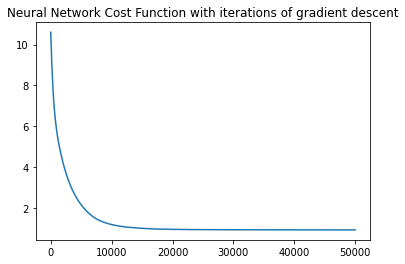

In [171]:
X = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GX.npy") #Load in the X and Y values from where they are stored
Y = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GY.npy")

Y_POSS = 5 #There are 5 possible categories of output result (5 G4G levels)
n_X = X.shape[0] #The number of input features.

#Convert Y to a one-hot matrix, meaning that it is TRAINING_EXAMPLES x Y_POSS, with all zeros, ones where the row number represents the column's correct answer e.g. [0,1] becomes [[1,0,0,0,0],[0,1,0,0,0]]
oneHotY = np.zeros((Y.shape[1],Y_POSS)) 
count = 0
for y in Y[0]: #Existing Y is a 1xTRAINING_EXAMPLES matrix of values in the range 0 to 4
    oneHotY[count][int(y)] = 1
    count += 1
oneHotY = oneHotY.T #We built it vertically but it needs to be horizontal based on the programming convention used here so transpose it

#Normalise features to have 0 mean and 1 standard deviation
mu = np.mean(X,axis=1).reshape(n_X,1)
sigma = np.std(X,axis=1).reshape(n_X,1)
for i in range(sigma.shape[0]):
    if sigma[i,0] == 0:
        sigma[i,0] = 1 #Some rows have 0 standard deviation which leads to division by zero error so just make the standard deviation 1 for now 
X -= mu
X /= sigma

#Split the dataset into train, cross-validation and test sets
PERCENTAGE_TRAIN = 0.7 
PERCENTAGE_CV = 0.15
NUMBER_TRAIN = round(PERCENTAGE_TRAIN * X.shape[1])
NUMBER_CV = round(PERCENTAGE_CV * X.shape[1])

trainX = X[:,:NUMBER_TRAIN]
cvX = X[:,NUMBER_TRAIN:NUMBER_TRAIN+NUMBER_CV]
testX = X[:,NUMBER_TRAIN+NUMBER_CV:]

trainY = oneHotY[:,:NUMBER_TRAIN]
cvY = oneHotY[:,NUMBER_TRAIN:NUMBER_TRAIN+NUMBER_CV]
testY = oneHotY[:,NUMBER_TRAIN+NUMBER_CV:]


m = trainX.shape[1] #Number of examples in training set

nodes = [n_X,10,Y_POSS] #This describes the architecture of the network (number of nodes in each layer). The activations are set elsewhere

#Randomly initialise weights and biases for each layer
Ws = [] #Each value in this array is a numpy matrix representing the weights for the transition from a pair of consecutive layers. len(Ws) === len(nodes)-1
for i in range(len(nodes)-1):
    Ws.append(np.random.standard_normal((nodes[i+1],nodes[i])))
bs = []#Each value in this array is a numpy matrix representing the biases for the transition from a pair of consecutive layers. len(bs) === len(nodes)-1
for i in range(len(nodes)-1):
    bs.append(np.random.standard_normal((nodes[i+1],1)))

def tanh(matrix):
    """The hyperbolic tangent activation function. Used as the default activation for all layers except the last one here"""
    return (np.exp(matrix) - np.exp(-matrix))/(np.exp(matrix)+np.exp(-matrix))

def tanh_prime(matrix):
    """Derivative of the hyperbolic tangent activation function with respect to the input matrix"""
    return 1-np.square(tanh(matrix))

def softmax(matrix):
    """Computes the soft maximum vector-valued activation function on each column of a matrix. Used as the final layer activation since we are doing multiclass classification"""
    temp = np.exp(matrix) #Compute elementwise e^n where e is Euler's number ~ 2.718
    return temp/np.sum(temp,axis=0) #Normalise the result so that the columns sum to 1, by dividing through by columnwise sum

def forwardProp(X,Ws,bs): 
    """Performs 1 forward propagation through the network to get a predicted class (code level) for X (input features - each column is one training example so vectorised), Ws (list of weights), bs (list of biases)"""
    As = [X] #Activations at each layer, with layer 0 having the input features as its activations
    Zs = [] #Z values (input to the activation function === matrix product of Ws[current layer] and a[layer before] + bs[current layer])
    
    for i in range(len(Ws)-1): #For every layer in the network except the last one, which is dealt with separately as it has a different activation,
        Zs.append(np.matmul(Ws[i],As[i]) + bs[i]) #Compute the next Z value by multiplying the corresponding weights with the previous layer's activations and adding the biases
        As.append(tanh(Zs[-1])) #Compute this layer's activation by applying the tanh activation function

    #Forward prop the final layer
    Z_final = np.matmul(Ws[-1],As[-1]) + bs[-1] #Compute Z as usual 
    Zs.append(Z_final) #Save the final Z value
    As.append(softmax(Z_final)) #Compute the softmax activation over the final logits and save as the final activations.
    return Zs,As #Return the Z and Activation values, which will be needed for backprop 

def classifyCodeLevel(featureMatrix,Ws,bs):
    """Runs forward propagation on the network with the provided weights and input features and returns the final layer activations which is a matrix of probabilities for each possible classification"""
    Zs, As = forwardProp(X,Ws,bs)
    return As[-1] #===y_hat

def accuracyMetrics(X,Ws,bs,Y):
    """Compute some accuracy metrics for the Ws and bs that we have trained, against a given X-Y supervised learning data pair"""
    Y_hat = classifyCodeLevel(X,Ws,bs) #Run forward propagation to get a prediction
    totalCorrect = np.sum(np.argmax(Y,axis=0) == np.argmax(Y_hat,axis=0)) #Predict the class with the maximum probablity in each case and check if it matches the expected one, producing a boolean matrix. Sum this matrix (True treated as 1, False as 0) to get the total number of correct ones.  
    percentCorrect = totalCorrect/Y.shape[1]*100
    diffs = np.abs(np.argmax(Y,axis=0) - np.argmax(Y_hat,axis=0)) #This variable is a matrix of values representing the absolute difference (number of classes) between the correct class value and the prediciton, for each input column. This is interesting in this case because the classes have an inherent order to them, meaning that if we classify say a Medium resoure as Easy that isn't as bad as classifying a Basic resource as Expert for example, so as well as the absolute percentage number of correctly predicted values, we are interested in how close we were when incorrect
    
    #Output what we have calculated
    print("Y - ground truth labels")
    print(np.argmax(Y,axis=0))
    print("Y-hat - predictions for these truth labels")
    print(np.argmax(Y_hat,axis=0))
    print("% Accuracy")
    print(percentCorrect)
    print("Absolute difference between Y and Y-hat in each case - smaller is better")
    print(diffs)

def computeCost(X,Ws,bs,Y,lamd):
    """Computes the neural network cost function for the parameters Ws (weights), bs (biases) on input X and ground truth labels Y. lamd is the regularisation parameter lambda"""
    Zs,As = forwardProp(X,Ws,bs) #Perform forward propagation to get the Zs and As. We will need to pass these back to the calling code for backprop
    Y_hat = As[-1] #Classification predictions 
    m = Y.shape[1] #Number of training examples (needed as we average the cost over all training examples)
    J = -1/m * np.sum(Y*np.log(Y_hat)) + lamd/(2*m)*sum([np.sum(np.square(w)) for w in Ws]) #Cross entropy loss for softmax regression multiway classification with Frobenius norm regularisation (results in a scalar value - the smaller the value the better the neural network is doing)
    return J,Zs,As #Cost, Zs, Activations

def train(X,Ws,bs,Y,iter,alpha,lamd):
    """Train a deep neural network with initial parameters Ws, bs, for iter iterations, with input features X and ground truth labels Y, with batch gradient descent (learning rate alpha) and weight decay regularisation parameter lamd"""
    Js = [] #We will save the costs on each iteration to be able to plot them later to see that they are decreasing monotonically
    m = Y.shape[1] #Number of training examples

    for i in range(iter): #For each iteration, perform forward prop, get cost, perform backprop by gradient descent and update weights
        cost,Zs,As = computeCost(X,Ws,bs,Y,lamd)
        Js.append(cost)

        dZ = As[-1] - Y #Derivative of the cost function with respect to the final layer logits Z
        dWs = copy.deepcopy(Ws) #The derivatives of the cost function with respect to each layer's weights..
        dbs = copy.deepcopy(bs) #...and biases. We use copy to initialise a dummy list of matrices with the correct dimensions although the values will be replaced - the W and dW values are not the same
        
        for backwardLayer in range(len(As)-2,-1,-1): #Move backward through the network, starting at the second to last set of activations
            dWs[backwardLayer] = 1/m*np.matmul(dZ,As[backwardLayer].T) + lamd/m*Ws[backwardLayer] #Compute the partial derivative with respect to the cost function J of the weights at this layer
            dbs[backwardLayer] = 1/m*np.sum(dZ,axis=1,keepdims=True) #Compute the partial derivative with respect to the cost function J of the biases at this layer
            
            if backwardLayer != 0: #If we are not back at the start of the network, then there is at least one more iteration (set of dW and db values to compute) and so we need to compute the parital derivative of J with respect to the next set of Z values, since this is used to compute the next layer's dW and db
                dZ = np.matmul(Ws[backwardLayer].T,dZ)*tanh_prime(Zs[backwardLayer-1])

        for i in range(len(Ws)): #Apply gradients via gradient descent to update the weights so that they hopefully get it right next time
            Ws[i] = Ws[i] - alpha*dWs[i]
            bs[i] = bs[i] - alpha*dbs[i]

    plt.plot(Js) #debug plot of the cost function with iterations to check it is monotonically increasing
    plt.title("Neural Network Cost Function with iterations of gradient descent")
    return Ws,bs #Trained weights and biases go back to calling code

#MAINTENANCE: Network training constants - to improve performance of model try changing these and check train and cv set accuracy. Use test set to get a final unbiased estimate of how good the model is
NUM_ITER = 50000 #How many epochs to train for
ALPHA = 0.005 #Gradient descent learning rate
LAMBDA = 5 #Regularisation parameter

trainedWs,trainedbs = train(trainX,Ws,bs,trainY,NUM_ITER,ALPHA,LAMBDA) #Train the network
print("\nTrain set")
accuracyMetrics(trainX,trainedWs,trainedbs,trainY) #Compute accuracy metrics on the train set
print("\nCV set")
accuracyMetrics(cvX,trainedWs,trainedbs,cvY) #Compute accuract metrics on the dev set

In [172]:
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GWs.npy",trainedWs) #Save weights as numpy binary for later import into Python code
np.save("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GBs.npy",trainedbs) #Save biases as numpy binary for later import into Python code

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [178]:
#Example code for loading in ws and bs to be used in the actual IDE code
w = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GWs.npy",allow_pickle=True)
b = np.load("/content/drive/MyDrive/A Level/Computer Science/NEA/G4GBs.npy",allow_pickle=True)
print(w)
print(b)
accuracyMetrics(cvX,trainedWs,trainedbs,cvY)

[array([[ 0.00206988,  0.00095631,  0.00469641, -0.00152693,  0.0022755 ,
        -0.00003342,  0.00083247, -0.00133908, -0.00150213,  0.00066506,
         0.00312203,  0.00056154,  0.00020423,  0.00017354,  0.0001447 ,
        -0.00043831, -0.00119037,  0.00098773, -0.00044784,  0.00029425,
         0.00020859,  0.00171452, -0.00344032,  0.00093779, -0.00362386,
        -0.00149425, -0.00149829,  0.00055674,  0.00030257,  0.0047335 ,
        -0.00186289,  0.00092605, -0.00059859,  0.00007881, -0.00056371,
         0.00134754, -0.00490444, -0.00300666],
       [-0.07927648, -0.22697926, -0.43731589,  0.06613232,  0.28863415,
        -0.00055396,  0.0966825 ,  0.05879437, -0.04429736, -0.05648122,
         0.00484645,  0.03885199,  0.18836305,  0.06323056, -0.18809601,
         0.09377438, -0.06938473, -0.36520545,  0.07712336, -0.01042315,
         0.14215354,  0.11525844, -0.14297306,  0.17972236, -0.06524108,
        -0.03714535, -0.26711057,  0.1271107 ,  0.00004888, -0.48011663,
  